In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
!unzip '/content/drive/MyDrive/DATASET1.zip'

Archive:  /content/drive/MyDrive/DATASET1.zip
replace DATASET/TRAIN/downdog/00000000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [27]:
image_size = (200, 200)
batch_size = 32

train_ds = image_dataset_from_directory(
    "/content/DATASET/TRAIN",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds =image_dataset_from_directory(
    "/content/DATASET/TRAIN",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1549 files belonging to 5 classes.
Using 1240 files for training.
Found 1549 files belonging to 5 classes.
Using 309 files for validation.


In [28]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., # rescaling
                                   rotation_range = 40,  # for augmentation
                                   width_shift_range = 0.2,
                                   validation_split = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory("/content/DATASET/TRAIN",
                                                    batch_size = 32,
                                                    subset="training",
                                                    class_mode = 'categorical', 
                                                    target_size = (200, 200))

val_generator = train_datagen.flow_from_directory("/content/DATASET/TRAIN",
                                                subset = "validation",
                                                    batch_size = 32,
                                                    class_mode = 'categorical', 
                                                    target_size = (200, 200))

Found 1241 images belonging to 5 classes.
Found 308 images belonging to 5 classes.


In [29]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [30]:

INPUT_SHAPE = (200, 200, 3)

# get the VGG19 model
vgg_layers = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, 
                                               input_shape=INPUT_SHAPE)

vgg_layers.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [31]:
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras import regularizers
from sklearn.metrics import f1_score

In [32]:
model = tf.keras.models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_layers)

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(5, activation='softmax'))

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss='categorical_crossentropy', 
              metrics=['Precision','accuracy','Recall'])

# view model layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 6, 6, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               4718848   
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 5)                

In [33]:
EPOCHS = 7
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)
history = model.fit(train_generator, validation_data = val_generator,
                    callbacks=es_callback, 
                    epochs=EPOCHS,
                    verbose=1)

Epoch 1/7
39/39 [==============================] - 49s 1s/step - loss: 1.6597 - precision: 0.2973 - accuracy: 0.2256 - recall: 0.0089 - val_loss: 1.5703 - val_precision: 0.0000e+00 - val_accuracy: 0.2532 - val_recall: 0.0000e+00
Epoch 2/7
39/39 [==============================] - 44s 1s/step - loss: 1.6072 - precision: 0.3333 - accuracy: 0.2643 - recall: 0.0024 - val_loss: 1.3997 - val_precision: 0.0000e+00 - val_accuracy: 0.4643 - val_recall: 0.0000e+00
Epoch 3/7
39/39 [==============================] - 45s 1s/step - loss: 1.4451 - precision: 0.7381 - accuracy: 0.3876 - recall: 0.0500 - val_loss: 1.0560 - val_precision: 0.8958 - val_accuracy: 0.6331 - val_recall: 0.2792
Epoch 4/7
39/39 [==============================] - 45s 1s/step - loss: 1.1495 - precision: 0.7254 - accuracy: 0.5471 - recall: 0.3320 - val_loss: 0.7239 - val_precision: 0.8756 - val_accuracy: 0.7565 - val_recall: 0.5714
Epoch 5/7
39/39 [==============================] - 44s 1s/step - loss: 0.9220 - precision: 0.7876 - 

In [34]:
model.save("epoch7.h5")

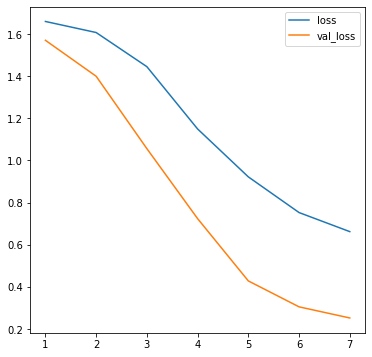

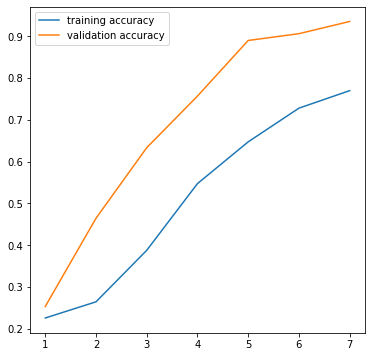

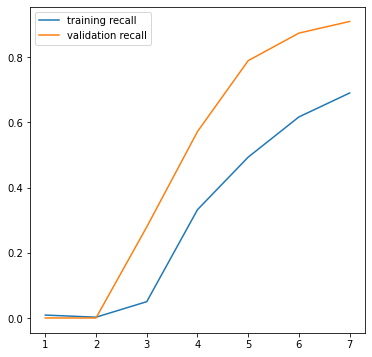

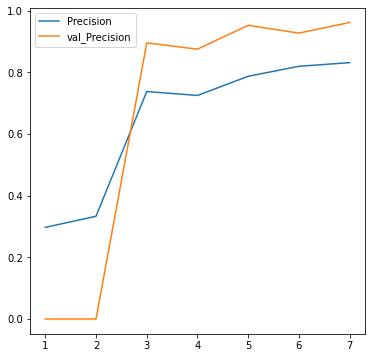

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6)) 
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,label='loss')
plt.plot(epochs,val_loss,label='val_loss')
plt.legend()

plt.figure(figsize=(6,6))

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
plt.plot(epochs,acc,label='training accuracy')
plt.plot(epochs,val_acc,label='validation accuracy')
plt.legend()


plt.figure(figsize=(6,6))

recall=history.history['recall']
val_recall=history.history['val_recall']
plt.plot(epochs,recall,label='training recall')
plt.plot(epochs,val_recall,label='validation recall')
plt.legend()

import matplotlib.pyplot as plt
plt.figure(figsize=(6,6)) 
Precision=history.history['precision']
val_Precision=history.history['val_precision']
epochs=range(1,len(Precision)+1)
plt.plot(epochs,Precision,label='Precision')
plt.plot(epochs,val_Precision,label='val_Precision')
plt.legend()
